In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
# ! pip install object_detection_metrics
from podm.metrics import get_pascal_voc_metrics, BoundingBox

In [2]:
# добавляет bounding box к изображению

RED = (255, 0, 0)

# bb - [top left point, bottom right point]
def add_bb(img, bb, color = RED, thickness=10):
    bb = np.array(bb).astype(int)
    if len(img.shape) == 2:
        rgb = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    else:
        rgb = img.copy()
    res = cv.rectangle(rgb, bb[0], bb[1], color, thickness)
    return res

### Считываем Test1 с разметкой (размечено вручную)

In [3]:
test1 = []
target_bbs1 = []
CATEGORY = 0
SCORE = 1

for i in range(47):
    if i < 9:
        prefix = '000'
    else:
        prefix = '00'
    img = cv.imread(f'./TestSet1/{prefix}{i + 1}.jpg', cv.IMREAD_GRAYSCALE)
    test1.append(img)
    
    res = img.copy()
    
    with open(f'./TestSet1Markup/{prefix}{i + 1}.txt') as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
        for line in lines:
            numbers = line.split(' ')
            bb = [float(num) for num in numbers] 
            
            xtl = int(bb[1])
            ytl = int(bb[0])
            xbr = int(bb[1] + bb[3])
            ybr = int(bb[0] + bb[2])
            bb = [[xtl, ytl], [xbr, ybr]]
            
            target_bbs1.append(BoundingBox.of_bbox(f'{prefix}{i + 1}', CATEGORY, int(bb[0][0]), int(bb[0][1]), int(bb[1][0]), int(bb[1][1]), SCORE))
            res = add_bb(res, bb, thickness=2)
    # uncomment to see markup
    # plt.imshow(res)
    # plt.show()

### Считываем Test2

In [4]:
test2 = []
target_bbs2 = []

for i in range(48):
    if i < 9:
        prefix = '000'
    else:
        prefix = '00'
    img = cv.imread(f'./TestSet2/{prefix}{i + 1}.jpg', cv.IMREAD_GRAYSCALE)
    test2.append(img)
    
    res = img.copy()
    
    with open(f'./TestSet2Markup/{prefix}{i + 1}.txt') as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
        for line in lines:
            numbers = line.split(' ')
            bb = [float(num) for num in numbers] 
            
            xtl = int(bb[1])
            ytl = int(bb[0])
            xbr = int(bb[1] + bb[3])
            ybr = int(bb[0] + bb[2])
            bb = [[xtl, ytl], [xbr, ybr]]
            
            target_bbs2.append(BoundingBox.of_bbox(f'{prefix}{i + 1}', CATEGORY, int(bb[0][0]), int(bb[0][1]), int(bb[1][0]), int(bb[1][1]), SCORE))
            res = add_bb(res, bb, thickness=2)
    # uncomment to see markup
    # plt.imshow(res)
    # plt.show()

In [5]:
len(test2)

48

In [6]:
img = test1[0]

In [7]:
%%time
qr_detector = cv.QRCodeDetector()
retval, points = qr_detector.detectMulti(img.copy())
print(retval)
print(points)

True
[[[ 909.     2192.    ]
  [1278.4575 2188.918 ]
  [1297.7273 2547.0164]
  [ 899.     2564.    ]]]
CPU times: user 383 ms, sys: 31.5 ms, total: 414 ms
Wall time: 352 ms


### Функции для подсчёта метрик 

In [8]:
x_top_left = 0.
y_top_left = 0.

x_bottom_right = 10.
y_bottom_right = 10.
bb = BoundingBox.of_bbox('img', CATEGORY, x_top_left, y_top_left, x_bottom_right, y_bottom_right, SCORE)

target = [bb]
prediction = [bb]

metrics = get_pascal_voc_metrics(target, prediction)

print(metrics[CATEGORY].precision)
print(metrics[CATEGORY].recall)

[1.]
[1.]


### преобразование над QR-кодом

In [9]:
points[0]

array([[ 909.    , 2192.    ],
       [1278.4575, 2188.918 ],
       [1297.7273, 2547.0164],
       [ 899.    , 2564.    ]], dtype=float32)

In [10]:
QR_CODE_SIZE = 800
QR_CODE_POINTS = np.float32([[0, 0], [QR_CODE_SIZE, 0], [QR_CODE_SIZE, QR_CODE_SIZE], [0, QR_CODE_SIZE]])
QR_CODE_SHAPE = (QR_CODE_SIZE, QR_CODE_SIZE)

transform_matrix = cv.getPerspectiveTransform(points[0], QR_CODE_POINTS)
_, inverse_matrix = cv.invert(transform_matrix)
res = cv.warpPerspective(img, transform_matrix, QR_CODE_SHAPE)

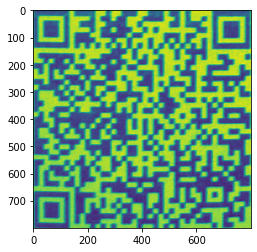

In [11]:
plt.imshow(res)

In [12]:
def find_bbs(res):
    # r = res.copy()
    bb1 = [[0, 0], [120, 120]]
    # r = add_bb(r, bb1, thickness=2)

    bb2 = [[0, 680], [120, 800]]
    # r = add_bb(r, bb2, thickness=2)

    bb3 = [[680, 0], [800, 120]]
    # r = add_bb(r, bb3, thickness=2)

    bbs = [bb1, bb2, bb3]
    return bbs

In [13]:
r = res.copy()
bb1 = [[0, 0], [130, 130]]
r = add_bb(r, bb1, thickness=2)

bb2 = [[0, 670], [130, 800]]
r = add_bb(r, bb2, thickness=2)

bb3 = [[670, 0], [800, 130]]
r = add_bb(r, bb3, thickness=2)

bbs = [bb1, bb2, bb3]

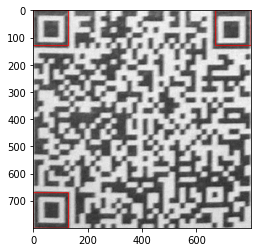

In [14]:
plt.imshow(r)

In [15]:
# вычисляет координаты bounding box-a на исходном изображении
def inverse_bb(inverse_matrix, bb):
    def inverse_point(point):
        x, y, z = inverse_matrix @ np.float32([point[0], point[1], 1])
        return [x / z, y / z]
    return inverse_point(bb[0]), inverse_point(bb[1])

In [16]:
new_bbs = []
for bb in bbs:
    new_bbs.append(inverse_bb(inverse_matrix, bb))

In [17]:
def get_tl_br(bb):
    l = min(bb[0][0], bb[1][0])
    r = max(bb[0][0], bb[1][0])
    t = min(bb[0][1], bb[1][1])
    b = max(bb[0][1], bb[1][1])
    return [[l, t], [r, b]]

In [18]:
predicted_bbs = []

res = img.copy()
for bb in new_bbs:
    bb = get_tl_br(bb)
    predicted_bbs.append(BoundingBox.of_bbox("img", CATEGORY, bb[0][0], bb[0][1], bb[1][0], bb[1][1], SCORE))
    res = add_bb(res, bb, thickness=2)

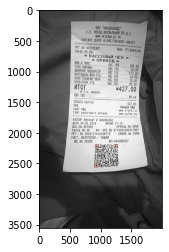

In [19]:
plt.imshow(res)
plt.show()

### Объединяем всё в один алгоритм

In [20]:
qr_detector = cv.QRCodeDetector()

def predict_bbs(img, img_name):
    predicted_bbs = []   
    ret, qr_codes = qr_detector.detectMulti(img)

    if not ret:
        return None
    
    # используется, только чтобы показать результат работы
    res = img.copy()
    
    for qr_code in qr_codes:
        transform_matrix = cv.getPerspectiveTransform(qr_code, QR_CODE_POINTS)
        _, inverse_matrix = cv.invert(transform_matrix)
        bbs_on_transformed = find_bbs(cv.warpPerspective(img, transform_matrix, QR_CODE_SHAPE))
        bbs = []
        for bb in bbs_on_transformed:
            bbs.append(inverse_bb(inverse_matrix, bb))
        
        for bb in bbs:
            bb = get_tl_br(bb)
            # print(f"Bounding box: {int(bb[0][0])}, {int(bb[0][1])}, {int(bb[1][0])}, {int(bb[1][1])}")
            predicted_bbs.append(BoundingBox.of_bbox(img_name, CATEGORY, int(bb[0][0]), int(bb[0][1]), int(bb[1][0]), int(bb[1][1]), SCORE))
            res = add_bb(res, bb, thickness=2)
            
    # uncomment to see markup
    # plt.imshow(res)
    # plt.show()
    return predicted_bbs

In [21]:
%%time
predicted_bbs1 = []

for i, img in enumerate(test1):
    if i < 9:
        prefix = '000'
    else:
        prefix = '00'
    img_name = f"{prefix}{i + 1}"
    pred = predict_bbs(img, img_name)
    if pred is None:
        # print("QR code not detected")
        continue
    predicted_bbs1.extend(pred)

CPU times: user 10min 50s, sys: 1min 5s, total: 11min 56s
Wall time: 4min 33s


### Время работы на одном изображении: 5.8 сек

In [22]:
metrics = get_pascal_voc_metrics(target_bbs1, predicted_bbs1)

print(f"Precision: {metrics[CATEGORY].precision[-1]}")
print(f"Recall: {metrics[CATEGORY].recall[-1]}")

Precision: 0.8817204301075269
Recall: 0.5694444444444444


In [23]:
%%time
predicted_bbs2 = []

for i, img in enumerate(test2):
    if i < 9:
        prefix = '000'
    else:
        prefix = '00'
    img_name = f"{prefix}{i + 1}"
    pred = predict_bbs(img, img_name)
    if pred is None:
        # print("QR code not detected")
        continue
    predicted_bbs2.extend(pred)

CPU times: user 3min 13s, sys: 20 s, total: 3min 33s
Wall time: 1min 34s


In [24]:
metrics = get_pascal_voc_metrics(target_bbs2, predicted_bbs2)

print(f"Precision: {metrics[CATEGORY].precision[-1]}")
print(f"Recall: {metrics[CATEGORY].recall[-1]}")

Precision: 0.8444444444444444
Recall: 0.5277777777777778
